In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
df = pd.read_csv('../input/insurance.csv')
df.head()

# Any results you write to the current directory are saved as output.

['insurance.csv']


,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [20]:
#no missing values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 7 columns):
age         348 non-null int64
sex         348 non-null int64
bmi         348 non-null float64
children    348 non-null int64
smoker      348 non-null int64
region      348 non-null int64
charges     348 non-null float64
dtypes: float64(2), int64(5)
memory usage: 19.1 KB


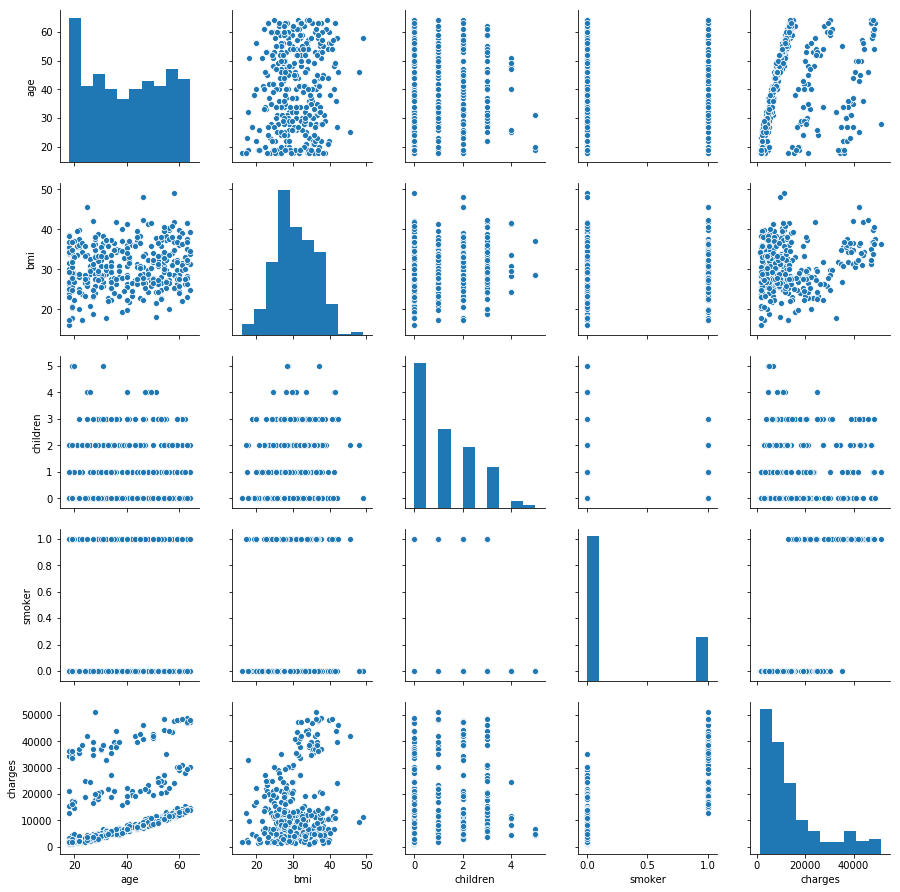

In [21]:
sns.pairplot(df[['age','bmi','children','smoker','charges']])

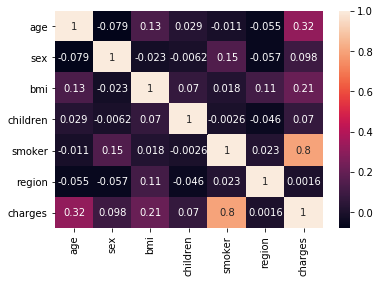

In [22]:
#heat map, smoking, age and bmi have a stronger relationship with charges
sns.heatmap(df.corr(), annot=True)

Text(0.5, 1.0, 'Number of children')

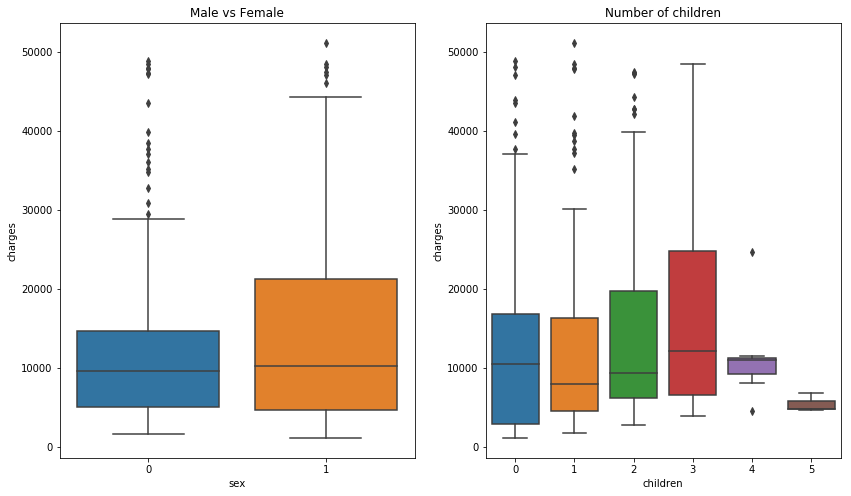

In [23]:
#male vs female and their charges, # of chilren and their charges
fig, ax = plt.subplots(1,2, figsize=(14,8))
sns.boxplot(x = 'sex',y='charges', data = df, ax=ax[0])
ax[0].set_title('Male vs Female')
sns.boxplot(x = 'children',y='charges', data = df, ax=ax[1])
ax[1].set_title('Number of children')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 8 columns):
age                348 non-null int64
sex                348 non-null int64
bmi                348 non-null float64
children           348 non-null int64
smoker             348 non-null int64
region             348 non-null int64
charges            348 non-null float64
children_binned    198 non-null category
dtypes: category(1), float64(2), int64(5)
memory usage: 19.6 KB


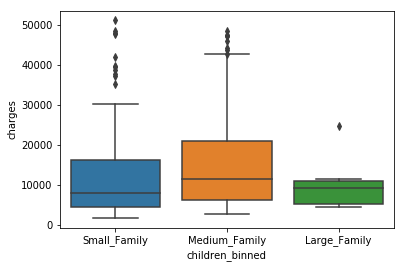

In [24]:
#binning, grouping # of children into family size
bins = [0,1,3,5]
labels = ['Small_Family','Medium_Family','Large_Family']
df['children_binned'] = pd.cut(df['children'], bins=bins, labels=labels)
sns.boxplot(x = 'children_binned',y='charges', data = df)

df.info()


In [33]:
#define the functions and the models

column_name = ['age', 'bmi']
def get_model(X_train, X_test, y_train, y_test, model):

    x_preprocessing = ColumnTransformer([('transformer', StandardScaler(), ['age', 'bmi'])], remainder='passthrough')
    x_preprocessing.fit(X_train)
    x_train_pre = x_preprocessing.transform(X_train)
    x_test_pre = x_preprocessing.transform(X_test)
              
    y_preprocessing = StandardScaler()
    y_preprocessing.fit(y_train)
    y_train_pre = y_preprocessing.transform(y_train)
    y_test_pre = y_preprocessing.transform(y_test)

    if model == 'LR':
        model = LinearRegression()
        model.fit(x_train_pre,y_train_pre)
        score = model.score(x_test_pre,y_test_pre)
        print(score)
        
    if model == 'RidgeCV':
        model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100, 1000])
        model.fit(x_train_pre,y_train_pre) 
        score = model.score(x_test_pre,y_test_pre) 
        print(score)
        
    if model == 'SGD':
        model = SGDRegressor(max_iter=1000, tol=1e-3)
        model.fit(x_train_pre,y_train_pre)
        score = model.score(x_test_pre,y_test_pre) 
        print(score)
        
    if model == 'xgboost':
        model = XGBRegressor()
        model.fit(x_train_pre,y_train_pre, eval_metric = 'error',eval_set = [(x_test_pre,y_test_pre)],verbose = False) 
        score = model.score(x_test_pre,y_test_pre) 
        print(score)
        
        


In [37]:
#dummy variables, creating x and y inputs

df_2 = pd.get_dummies(df, columns = ['children_binned','region'])
df_2.head()
df_2 = df_2.drop(['children'], axis = 1)

df_x = df_2.loc[:, df_2.columns != 'charges']
df_y = df_2[['charges']]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_x, df_y, test_size=0.33, random_state=42)

,age,sex,bmi,smoker,children_binned_Small_Family,children_binned_Medium_Family,children_binned_Large_Family,region_0,region_1,region_2,region_3
256,56,1,33.630,1,0,0,0,0,1,0,0
238,19,1,29.070,1,0,0,0,0,1,0,0
288,59,0,36.765,1,1,0,0,1,0,0,0
303,28,0,33.000,0,0,1,0,0,0,1,0
59,34,0,37.335,0,0,1,0,0,1,0,0


In [36]:
#run the models
for i in ['LR','RidgeCV','SGD','xgboost']:
    print(f"{i} score:")
    get_model(X_train = X_train_1, X_test = X_test_1, y_train = y_train_1, y_test =y_test_1, model = i)
    
#XGboost has the highest accuracy

LR score:
0.7719009869863309
RidgeCV score:
0.7689675741325546
SGD score:
0.7400540497311674
xgboost score:
0.8665308060566922


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to 